# Example of PSF Fitting Using Mock Data

## Step 1: Prepare Mock Input Data for PSF Fitting

Import the required objects for creating mock input data to demonstrate PSF fitting.

In [2]:
from matplotlib import pyplot
import numpy
from ctypes import c_ubyte

import sys
sys.path.insert(0, '/Users/kpenev/projects/git/SuperPhot/PythonPackage')
sys.path.insert(0, '/Users/kpenev/projects/git/SuperPhot/PythonPackage/tests')

from superphot.fake_image.piecewise_bicubic_psf import PiecewiseBicubicPSF
from test_fit_star_shape.utils import make_image_and_source_list

Create a mock image, sub-pixel map and list of sources to demonstrate PSF fitting.

The properties of the created items are:

  * The image contains a single source with center at (5, 5).

  * The PSF is on a bicubic grid with x boundaries -2, 0 and 2 and y boundaries -1, 0, 1 relative to the center.
  
  * The PSF, its first order derivatives and the x-y cross derivative are all zero at the boundaries
    $$x=\pm2 \quad\mathrm{or}\quad y=\pm1$$
    
  * The first order derivative and the x-y cross derivative are zero at the center (x=0, y=0) and the values is 1 ADU.
  
  * The image has a background of 1 ADU
  
  * The source list contains exactly the following columns: `ID`, `x` and `y` giving a unique Id for the source and 
    the position of its center in the image
    
  * The sub-pixel map is a good approximation for the effective sensitivity map that should be used for DSLR cameras, 
    which stagger 4 channels on the image, and hence only a quarter of each "pixel" is sensitive for each channel

Source list:array([(b'000000', 5., 5.)],
      dtype=[('ID', 'S6'), ('x', '<f8'), ('y', '<f8')])


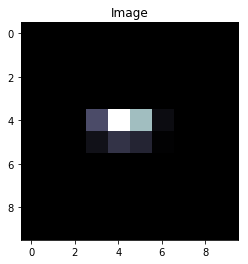

In [3]:
subpix_map = numpy.array([[0.0, 0.0], [0.0, 4.0]])

values = numpy.zeros((3, 3))
d_dx = numpy.zeros((3, 3))
d_dy = numpy.zeros((3, 3))
d2_dxdy = numpy.zeros((3, 3))
values[1, 1] = 1.0
        
sources = [
    dict(
        x=5.0,
        y=5.0,
        psf=PiecewiseBicubicPSF(
            psf_parameters=dict(
                values=values,
                d_dx=d_dx,
                d_dy=d_dy,
                d2_dxdy=d2_dxdy
            ),
            boundaries=dict(x=numpy.array([-2.0, 0.0, 2.0]),
                            y=numpy.array([-1.0, 0.0, 1.0]))
        )
    )
]

image, source_list = make_image_and_source_list(sources, extra_variables=[], subpix_map=subpix_map)
pyplot.imshow(image, cmap=pyplot.cm.bone)
pyplot.title('Image')
print('Source list:' + repr(source_list))

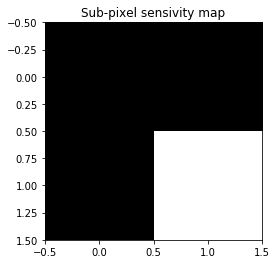

In [4]:
pyplot.imshow(subpix_map, cmap=pyplot.cm.bone)
pyplot.title('Sub-pixel sensivity map');

## Step 2: Perform the PSF Fitting

Import the required objects for PSF fitting and Background extraction

In [5]:
from superphot import FitStarShape, BackgroundExtractor

Construct a PSF fitting object

In [6]:
fit_star_shape = FitStarShape(
    mode='PSF', # use PSF fitting (as opposed to PRF)
    shape_terms='{1}', # Assume the PSF is the same for all sources
    grid=[numpy.array([-2.0, 0.0, 2.0]),
          numpy.array([-1.0, 0.0, 1.0])], # Use the same grid that was used to create the sources
    initial_aperture=3.0, # Initial guess for source flux will be measured using an aperture with radius 3 pixels
    subpixmap=subpix_map, # Assume the same sub-pixel map that was used to generate the image
    max_abs_amplitude_change=0.0, # Force convergence based entirely on relative change in the amplitudes
    max_rel_amplitude_change=1e-6, # Require that the flux estimates change by no more than ppm for convergence
    bg_min_pix=3 #Require that the background is determined using at least 3 pixels
)

Measure the background behind the sources.

In [7]:
background = BackgroundExtractor(
    image,
    3, # Include only pixels with centers at least 3 pixels away from the source center.
    6  # Include only pixels with centers at most 6 pixels away from the source center.
)
background(
    numpy.array([5.0]), # list of source x coordinates
    numpy.array([5.0])  # list of source y coordinates
);

Find the best-fit PSF shape.

In [8]:
result_tree = fit_star_shape.fit(
    [
        (
            image, # The pixel values in the image
            image**0.5, # Standard deviations of the pixels values (assume Poisson noise only and gain of 1)
            numpy.zeros(image.shape, dtype=c_ubyte),
            source_list
        )
    ],
    [background]
)

In [9]:
print('PSF map coefficients: ' + repr(result_tree.get('psffit.psfmap', shape=(4,))))
print('PSF fit flux: ' + repr(result_tree.get('psffit.flux.0', shape=(1,))))

PSF map coefficients: array([ 5.00000000e-01,  1.51662586e-16, -1.65018810e-17, -2.77749592e-15])
PSF fit flux: array([2.])


# Aperture Photometry

Import the aperture photometry object

In [10]:
from superphot import SubPixPhot

Construct an aperture photometry object

In [ ]:
do_apphot = SubPixPhot(subpixmap=subpix_map,
                       apertures=[1.0, 2.0, 3.0])